# Google Drive Interface Setup

In [1]:
from google.colab import drive, auth
import sys

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Pull down github repo, store in colab runtime memory
!git clone https://github.com/andrew-loeber/proj_utils_207.git

Cloning into 'proj_utils_207'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 8.72 KiB | 8.72 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
# Tell Python to also look in this repo when running an import
sys.path.insert(1, "/content/proj_utils_207")

In [5]:
# Authenticate google account and give back the session access token
auth.authenticate_user()
gcloud_token = !gcloud auth print-access-token
gcloud_token

['ya29.a0AbVbY6MriAUQsb0Vl88CEb39u5saWx8V_uI4_bEgPLNCbxK1NOjUUMEjlTSIO_STw4W4BapRkWQBEhGbYNkRDn-cradGNtoRt7cxqHxKp2fZNJrGZ8s8J7DwmgpSIwQgRugKFdPFJzJYLpE4bUuks-7O8Z94aCgYKAWYSARMSFQFWKvPlGs4U9iBapRs11PMTqaxzWw0163']

In [6]:
from gdriveinterface import GDriveInterface
import proj_ref

In [7]:
# Show email address, username, and the path of the shared project folder on
# your Google Drive instance
gdi = GDriveInterface(gcloud_token)
shared_folder_path = gdi.shared_folder_path
gdi.__dict__

{'email': 'aloeber@berkeley.edu',
 'account': 'aloeber',
 'shared_folder_path': '/content/drive/MyDrive/207-Project'}

In [8]:
# Show name keys and paths for tracked files
proj_ref.files

{'taxonomy': 'BirdCLEF/eBird_Taxonomy_v2021.csv',
 'orig_metadata': 'BirdCLEF/train_metadata_with_duration.csv',
 'sample_metadata': 'data/sample_metadata.csv',
 'species_metadata': 'data/species_metadata.csv',
 'train_metadata': 'data/train_metadata.csv',
 'test_metadata': 'data/test_metadata.csv'}

In [9]:
# Show name keys and paths for tracked directories
proj_ref.dirs

{'orig_audio': {'path': 'BirdCLEF/train_audio'},
 'train_audio': {'path': 'data/train/audio_files'},
 'test_audio': {'path': 'data/test/audio_files'},
 'train_npy_full': {'path': 'data/train/librosa_loaded'},
 'test_npy_full': {'path': 'data/test/librosa_loaded'},
 'train_npy_loud5s': {'path': 'data/train/librosa_loaded_loudest_5sec'},
 'test_npy_loud5s': {'path': 'data/test/librosa_loaded_loudest_5sec'}}

### **Usage examples**

##### Query specific file based on named key
```
command: gdi.get_file_path('taxonomy')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/eBird_Taxonomy_v2021.csv'
```

##### Query specific directory based on named key
```
command: gdi.get_dir_path('orig_audio')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/train_audio'
```

##### Query specific sample record based on named keys for directory and file
```
command: gdi.get_sample_path('train_audio', 'barswa/XC132406.ogg')
returns: '/content/drive/MyDrive/207-Project/data/train/audio_files/barswa/XC132406.ogg'
```

##### Provide full path given a custom partial path
```
command: gdi.join_to_shared('images/sandpiper.jpeg')
returns: '/content/drive/MyDrive/207-Project/images/sandpiper.jpeg'
```


# Imports and Setup

In [10]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.3 MB/s eta 0:00:00


In [11]:
!pip install colorednoise

In [12]:
# !pip install tensorflow-addons

In [13]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
# import tensorflow_addons as tfa
import librosa
from IPython.display import Audio
import audiomentations as am
import colorednoise as cn
import gc

In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Read in metadata, audio files, frames, & labels

In [15]:
train_file_df = pd.read_csv(
    gdi.join_to_shared('3_species/train/file_df.csv')
)
train_file_df

,data,primary_label,primary_label_enc,filename,filename_npy,rating,type,type_enc,country,country_enc,continent,continent_enc,file_duration_s,file_duration_samples
0,train,comsan,1,comsan/XC746957.ogg,comsan/XC746957.npy,good,blank,0,DK,15,EUROPE,3,6.112000,97792
1,train,eaywag1,2,eaywag1/XC658750.ogg,eaywag1/XC658750.npy,good,call,2,DE,14,EUROPE,3,49.680000,794880
2,train,comsan,1,comsan/XC725160.ogg,comsan/XC725160.npy,good,blank,0,EE,16,EUROPE,3,6.635000,106160
3,train,comsan,1,comsan/XC430908.ogg,comsan/XC430908.npy,good,call,2,RU,46,EUROPE,3,15.255500,244088
4,train,eaywag1,2,eaywag1/XC507677.ogg,eaywag1/XC507677.npy,poor,call,2,GB,20,EUROPE,3,17.397562,278361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,train,comsan,1,comsan/XC432940.ogg,comsan/XC432940.npy,good,call,2,NL,41,EUROPE,3,12.408000,198528
653,train,comsan,1,comsan/XC199825.ogg,comsan/XC199825.npy,good,call,2,ES,17,EUROPE,3,8.376000,134016
654,train,eaywag1,2,eaywag1/XC687206.ogg,eaywag1/XC687206.npy,good,call,2,IE,26,EUROPE,3,152.633000,2442128
655,train,eaywag1,2,eaywag1/XC591908.ogg,eaywag1/XC591908.npy,good,call,2,PL,44,EUROPE,3,14.616000,233856


In [16]:
train_labels = np.load(gdi.join_to_shared('3_species/train/file_labels.npy'))
train_labels[0:5]

array([1, 2, 1, 1, 2])

In [17]:
train_labels.shape

(657,)

In [18]:
# train_frames = np.load(gdi.join_to_shared('3_species/train/frames.npy'))
# train_frames[0:5]

In [19]:
# train_frames.shape

In [20]:
train_files_filepath = gdi.join_to_shared('3_species/train/files.pkl')
with open(train_files_filepath, 'rb') as file:
  train_files = pkl.load(file)
train_files[0:5]

[array([ 5.9499580e-06, -1.0428121e-05, -2.0700150e-05, ...,
        -1.4326214e-02, -1.2398371e-02, -1.4604669e-02], dtype=float32),
 array([-1.1132361e-06,  4.6719542e-06, -4.7960584e-06, ...,
        -7.4155294e-05, -4.1194289e-07,  9.1129157e-05], dtype=float32),
 array([-2.3218287e-05, -7.0027181e-06,  2.3201643e-05, ...,
        -6.9095149e-06, -2.1964188e-06,  5.6537119e-06], dtype=float32),
 array([ 1.0609627e-05,  4.7013164e-06,  6.1467290e-07, ...,
        -7.4523976e-03, -9.0304529e-03, -1.1077991e-02], dtype=float32),
 array([ 1.00838915e-05, -1.91047661e-06,  2.31165677e-06, ...,
        -9.90291737e-05,  2.73336598e-04, -1.12968672e-04], dtype=float32)]

In [21]:
train_files = [file - np.mean(file) for file in train_files.copy()]
train_files[0:5]

[array([ 0.00204584,  0.00202946,  0.00201919, ..., -0.01228633,
        -0.01035848, -0.01256478], dtype=float32),
 array([-1.1120907e-06,  4.6730997e-06, -4.7949129e-06, ...,
        -7.4154152e-05, -4.1079747e-07,  9.1130300e-05], dtype=float32),
 array([-2.3099887e-05, -6.8843183e-06,  2.3320043e-05, ...,
        -6.7911151e-06, -2.0780190e-06,  5.7721118e-06], dtype=float32),
 array([ 6.4127235e-05,  5.8218928e-05,  5.4132284e-05, ...,
        -7.3988801e-03, -8.9769354e-03, -1.1024473e-02], dtype=float32),
 array([ 1.0048502e-05, -1.9458657e-06,  2.2762677e-06, ...,
        -9.9064564e-05,  2.7330121e-04, -1.1300406e-04], dtype=float32)]

In [22]:
train_sizes = np.array(train_file_df['file_duration_samples'])
train_sizes[0:10]

array([  97792,  794880,  106160,  244088,  278361,  325172, 1077081,
        461568,  714704, 4829519])

In [23]:
train_durations = np.array(train_file_df['file_duration_s'])
train_durations[:10]

array([  6.112     ,  49.68      ,   6.635     ,  15.2555    ,
        17.3975625 ,  20.32325   ,  67.3175625 ,  28.848     ,
        44.669     , 301.84490625])

In [24]:
# train_sample_wts = np.array([ ((dur - 5.0) / 2.5) + 1 for dur in train_durations ])
# train_sample_wts /= np.mean(train_sample_wts)
# train_sample_wts

In [25]:
# train_sample_weights = np.array(train_file_df['file_duration_s'])
# train_sample_weights /= np.mean(train_sample_weights)
# train_sample_weights[0:10]

In [26]:
val_frame_df = pd.read_csv(
    gdi.join_to_shared('3_species/val/frame_df.csv')
)
val_frame_df

,data,primary_label,primary_label_enc,filename,filename_npy,rating,type,type_enc,country,country_enc,continent,continent_enc,file_duration_s,file_duration_samples,frame_length_s,hop_length_s,total_frames,frame_id
0,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,1
1,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,2
2,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,3
3,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,4
4,val,barswa,0,barswa/XC57672.ogg,barswa/XC57672.npy,good,song,3,UNKNOWN,55,UNKNOWN,4,40.960000,655360,5.0,2.5,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,19
3117,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,20
3118,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,21
3119,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,22


In [27]:
val_frame_labels = np.load(gdi.join_to_shared('3_species/val/frame_labels.npy'))
val_frame_labels[0:5]

array([1, 1, 1, 1, 0])

In [28]:
val_frame_labels.shape

(3121,)

In [29]:
val_frames = np.load(gdi.join_to_shared('3_species/val/frames.npy'))
val_frames[0:5]

array([[-2.70812802e-06,  2.27731789e-06,  6.10671464e-07, ...,
         4.44087666e-04, -1.34347146e-02,  4.17729001e-03],
       [ 1.13037531e-03,  4.36404441e-03,  5.12790517e-04, ...,
        -3.71276285e-04,  3.11362371e-03, -1.08309905e-03],
       [ 1.22987926e-02, -7.29914336e-03, -5.96568920e-03, ...,
        -2.97210005e-04, -2.47759186e-03, -2.29351601e-04],
       [ 1.11260731e-03,  3.40224011e-04, -8.38086358e-04, ...,
         2.87609873e-03, -4.81321616e-03,  1.80263212e-03],
       [ 3.00267129e-06, -6.75930642e-06, -2.86684372e-06, ...,
        -1.03749875e-02, -9.73683130e-03, -7.67644681e-03]], dtype=float32)

In [30]:
val_frames.shape

(3121, 80000)

# Define helper functions

In [48]:
def get_random_clip(
    audio
    , rng
    , clip_len=80000
    ):
  audio_len = len(audio)
  clip_start = rng.integers(audio_len - clip_len)
  clip_locs = (clip_start, clip_start + clip_len)
  return audio[clip_locs[0] : clip_locs[1]].copy()


In [49]:
def audio_to_stft(
    audio
    , n_fft=128
    , hop_length=64):

  S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  S = np.abs(S)
  S_min, S_max = np.min(S), np.max(S)
  S_range = S_max - S_min
  return (S - S_min) / S_range

In [50]:
def audio_to_db_stft(
    audio
    , n_fft=128
    , hop_length=64):

  S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  S = np.abs(S)
  S = librosa.amplitude_to_db(S, ref=np.max)
  S -= np.mean(S)
  S /= np.std(S)
  return S

In [51]:
def audio_to_db_melspec(
    audio
    , fmin=50
    , hop_length=128
    , n_mels=32):

  S = librosa.feature.melspectrogram(
    y=audio
    , sr=16000
    , fmin=fmin
    , hop_length=hop_length
    , n_mels=n_mels
  )

  S = librosa.power_to_db(S)
  S -= np.mean(S)
  S /= np.std(S)
  return S


In [52]:
def audio_to_mfcc(
    audio
    , sr=16000
    , hop_length=128
    , n_mfcc=16
    , fmin=50
    , lifter=0
    ):

  M = librosa.feature.mfcc(
    y=audio
    , sr=sr
    , hop_length=hop_length
    , n_mfcc=n_mfcc
    , lifter=lifter
    , fmin=fmin
  )
  M -= np.expand_dims(np.mean(M, axis=1), axis=1)
  M /= np.expand_dims(np.std(M, axis=1), axis=1)

  return M


In [53]:
def audio_to_melspec_and_mfcc(
    audio
    ):
  S = audio_to_db_melspec(audio)
  M = audio_to_mfcc(audio)
  return np.concatenate([S,M], axis=0)

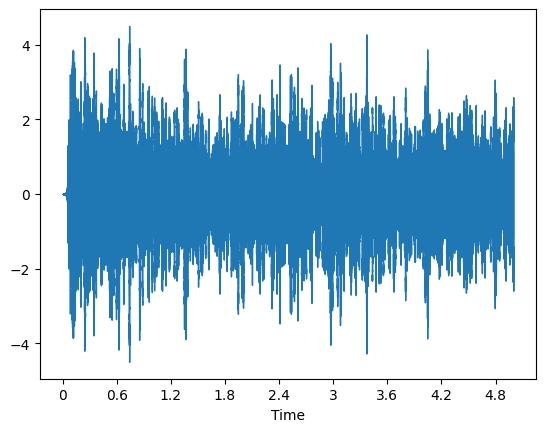

In [54]:
sample_audio = train_files[13][0:80000]
librosa.display.waveshow(sample_audio * 100, sr=16000)

In [55]:
Audio(sample_audio * 100, rate=16000)

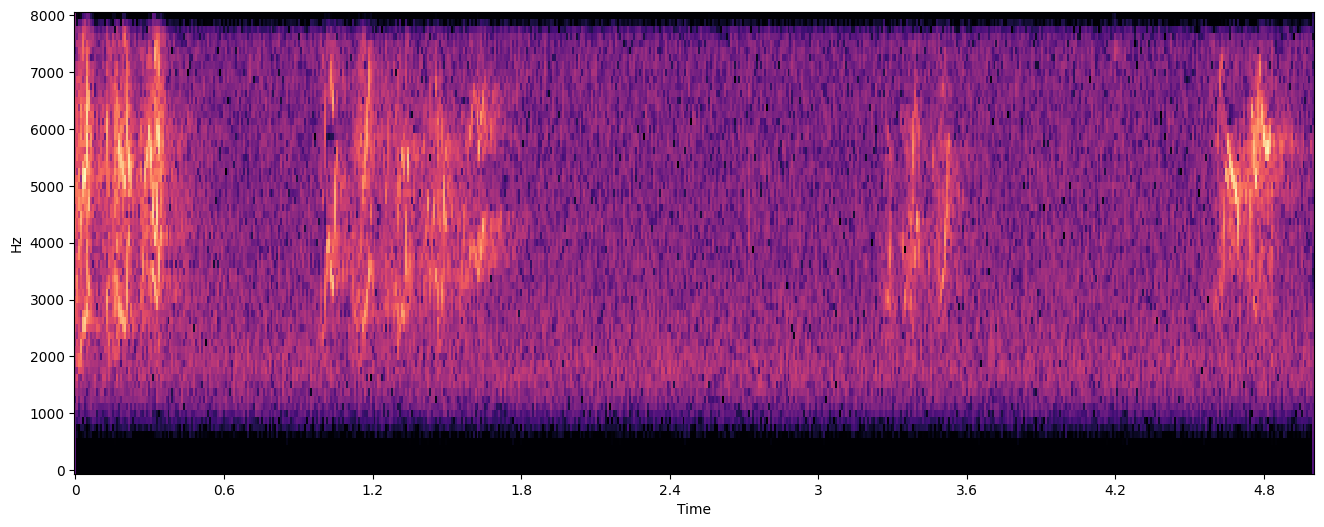

In [114]:
plt.figure(figsize=(16,6))
S = librosa.stft(
    y=sample_audio
    , hop_length=128
    , n_fft=128)

S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

librosa.display.specshow(
    S_db
    , sr=16000
    , hop_length=128
    , x_axis='time'
    , y_axis='linear'
)

In [115]:
S_db.shape

(65, 626)

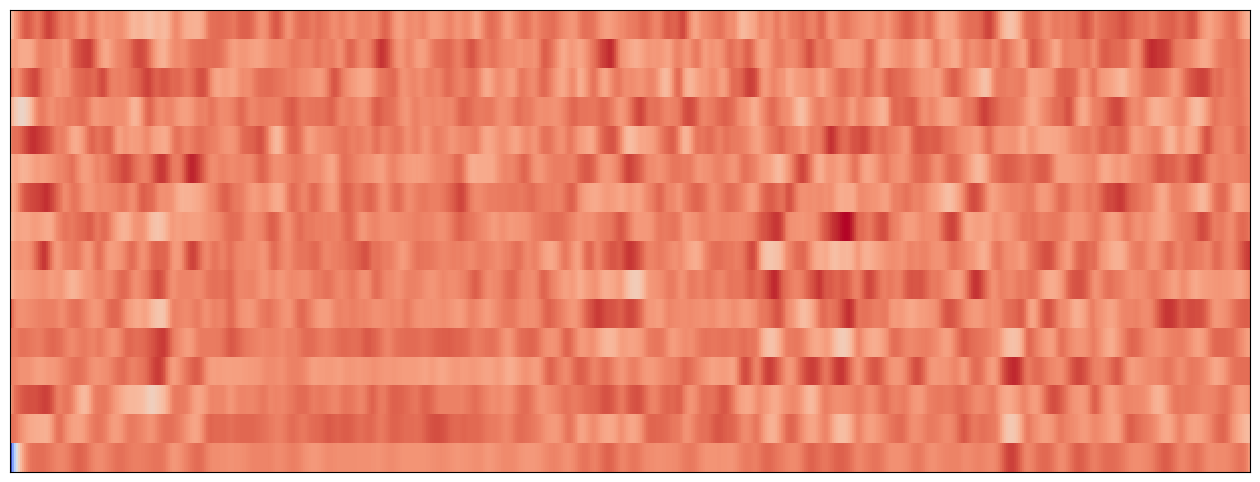

In [57]:
plt.figure(figsize=(16,6))
# mfcc = librosa.feature.mfcc(
#     y=sample_audio*500
#     , sr=16000
#     , hop_length=512
#     , n_mfcc=20
#     # , n_mels=128
#     , fmin=300
#     , lifter=0)

mfcc = audio_to_mfcc(sample_audio, n_mfcc=16, hop_length=128)

librosa.display.specshow(mfcc)

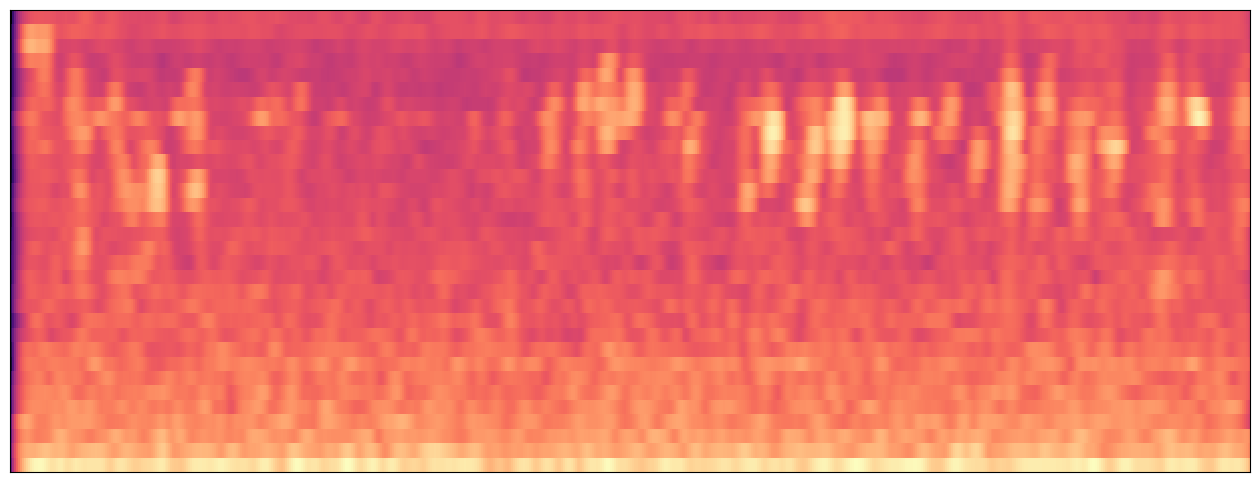

In [67]:
mel_spec = librosa.feature.melspectrogram(
    y=sample_audio
    , sr=16000
    , fmin=50
    , hop_length=128
    , n_mels=32
)

mel_spec_db = librosa.power_to_db(mel_spec)

plt.figure(figsize=(16,6))
librosa.display.specshow(mel_spec_db)

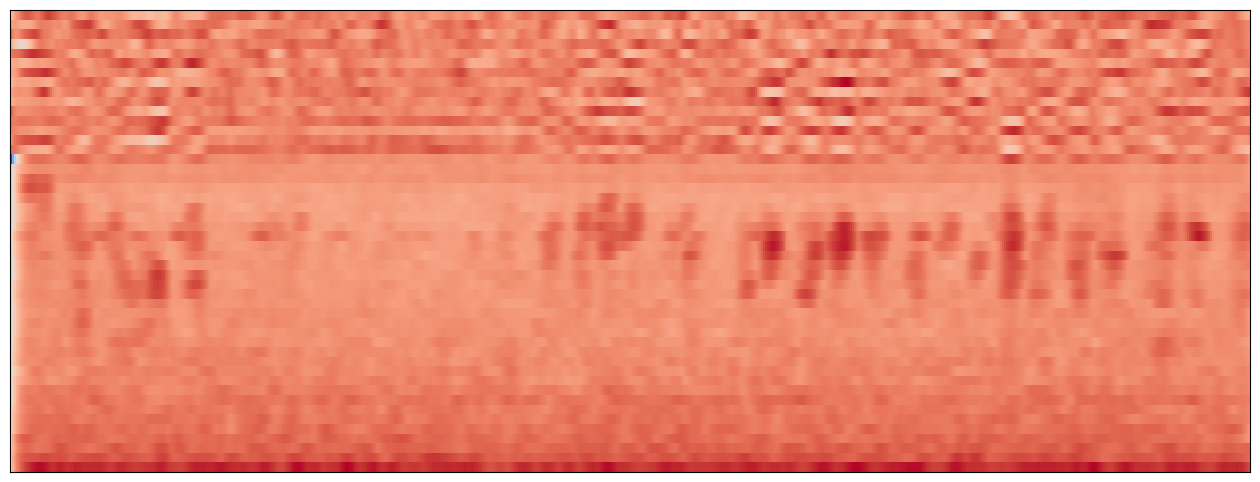

In [59]:
plt.figure(figsize=(16,6))
librosa.display.specshow(audio_to_melspec_and_mfcc(sample_audio))

In [60]:
np.min(mel_spec_db)

-72.06016

In [61]:
mfcc.shape

(16, 626)

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.300e+01,
        3.560e+02, 4.582e+03, 4.656e+03, 4.050e+02]),
 array([-1.40571899e+01, -1.23002348e+01, -1.05432787e+01, -8.78632355e+00,
        -7.02936745e+00, -5.27241230e+00, -3.51545644e+00, -1.75850093e+00,
        -1.54533389e-03,  1.75541019e+00,  3.51236582e+00]),
 <BarContainer object of 10 artists>)

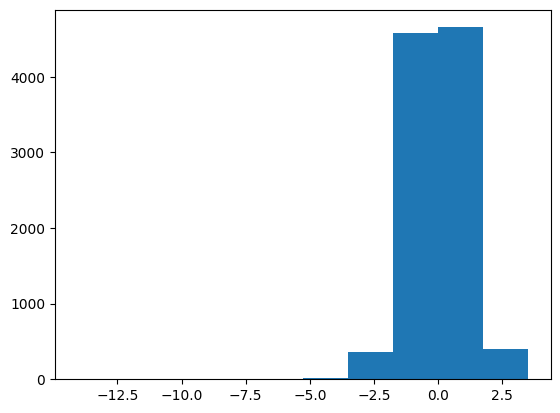

In [62]:
plt.hist(mfcc.flat)

In [63]:
def transform_frames(frames, transform, transform_args):
  return np.array([transform(frame.copy(), **transform_args) for frame in frames])

def transform_frame(frame, transform, transform_args):
  return transform(frame.copy(), **transform_args)

In [64]:
def audio_compress(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_compress(samples, mu=mu, quantize=False)

def audio_expand(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_expand(samples, mu=mu, quantize=False)

def add_silent_frames(samples, sample_rate, p_min=5e-5, p_max=1e-2):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=1-prob, size=len(samples))
  return (mask * samples).astype(np.float32)

def add_crackle(samples, sample_rate, p_min=1e-5, p_max=2e-4):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=prob, size=len(samples))
  noise = np.random.binomial(n=1, p=0.5, size=len(samples)) * 2 - 1
  return np.where(mask, noise, samples).astype(np.float32)

def add_colored_noise(
    samples
    , sample_rate
    , exp_min=-4
    , exp_max=2
    , scale_min=0.005
    , scale_max=0.025
    ):
  exp = np.random.uniform(low=exp_min, high=exp_max)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = cn.powerlaw_psd_gaussian(exp, size=len(samples))
  return samples + (scale * noise)

def add_colored_noise2(
    samples
    , sample_rate
    , min_gain_db=-18.0
    , max_gain_db=18.0
    , scale_min=0.005
    , scale_max=0.05
    ):
  eq = am.SevenBandParametricEQ(
      min_gain_db=min_gain_db
      , max_gain_db=max_gain_db
      , p=1.0
  )
  norm = am.Normalize(p=1.0)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = np.random.randn(len(samples))
  noise = eq(noise, sample_rate=sample_rate)
  noise = norm(noise, sample_rate=sample_rate)
  return samples + (scale * noise)

# Processing

In [68]:
%who

Audio	 GDriveInterface	 S	 S_db	 add_colored_noise	 add_colored_noise2	 add_crackle	 add_silent_frames	 am	 
audio_compress	 audio_expand	 audio_to_db_melspec	 audio_to_db_stft	 audio_to_melspec_and_mfcc	 audio_to_mfcc	 audio_to_stft	 auth	 cn	 
drive	 file	 gc	 gcloud_token	 gdi	 get_random_clip	 layers	 librosa	 mel_spec	 
mel_spec_db	 mfcc	 np	 pd	 pkl	 plt	 proj_ref	 sample_audio	 shared_folder_path	 
sns	 sys	 tf	 train_durations	 train_file_df	 train_files	 train_files_filepath	 train_labels	 train_sizes	 
transform_frame	 transform_frames	 val_frame_df	 val_frame_labels	 val_frames	 


In [69]:
gc.collect()

65

In [116]:
transform = audio_to_db_stft
transform_args = {'hop_length':128, 'n_fft':128}

In [117]:
val_features = transform_frames(val_frames, transform, transform_args)
val_features.shape

(3121, 65, 626)

In [ ]:
# del val_frames

In [118]:
gc.collect()

7444

In [ ]:
# plt.figure(figsize=(18,4))
# librosa.display.specshow(
#     val_features[1052,:,:]
#     , x_axis='time'
#     , y_axis='linear'
#     , sr=16000
#     , hop_length=64
# )

In [151]:
aug = am.Compose([
    # am.PitchShift(-2, 2, 0.25)
    # , am.Shift(-0.15, 0.15, False, p=1.0)
    am.Normalize(p=1.0)
    , am.OneOf([
        am.Lambda(transform=audio_compress, mu_min=1, mu_max=7, p=0.3)
        , am.Lambda(transform=audio_expand, mu_min=1, mu_max=11, p=0.3)
    ])

    , am.PeakingFilter(100, 2000, -15, 15, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(2000, 4000, -15, 15, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(4000, 6000, -15, 15, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(6000, 7500, -15, 15, 1.0, 5.0, p=0.35)
    , am.LowPassFilter(4000, 7000, 6, 24, p=0.35)
    , am.HighPassFilter(100, 2000, 6, 24, p=0.35)

    , am.TimeMask(0.025, 0.1, p=0.4)
    , am.TimeMask(0.025, 0.1, p=0.4)
    , am.TimeMask(0.025, 0.1, p=0.4)
    , am.TimeMask(0.025, 0.1, p=0.4)
    , am.TimeMask(0.025, 0.1, p=0.4)

    , am.Lambda(
        transform=add_colored_noise2
        , min_gain_db=-15.0
        , max_gain_db=15.0
        , scale_min=0.005
        , scale_max=0.1
        , p=0.65
    )

    , am.PeakingFilter(1000, 7000, -50, -38, 1, 2, 0.5)

    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_silent_frames, p=0.25)
    , am.Lambda(transform=add_crackle, p=0.25)
])

In [121]:
sample_audio_num = 1055
val_frame_df.iloc[sample_audio_num]

data                                     val
primary_label                         barswa
primary_label_enc                          0
filename                 barswa/XC457823.ogg
filename_npy             barswa/XC457823.npy
rating                                  good
type                                    call
type_enc                                   2
country                                   RU
country_enc                               46
continent                             EUROPE
continent_enc                              3
file_duration_s                       28.176
file_duration_samples                 450816
frame_length_s                           5.0
hop_length_s                             2.5
total_frames                              10
frame_id                                   2
Name: 1055, dtype: object

In [122]:
sample_audio = val_frames[sample_audio_num]
sample_audio

array([-0.00083433, -0.02356659,  0.00866812, ..., -0.00054706,
        0.00162184,  0.00188546], dtype=float32)

In [123]:
Audio(sample_audio, rate=16000, autoplay=True)

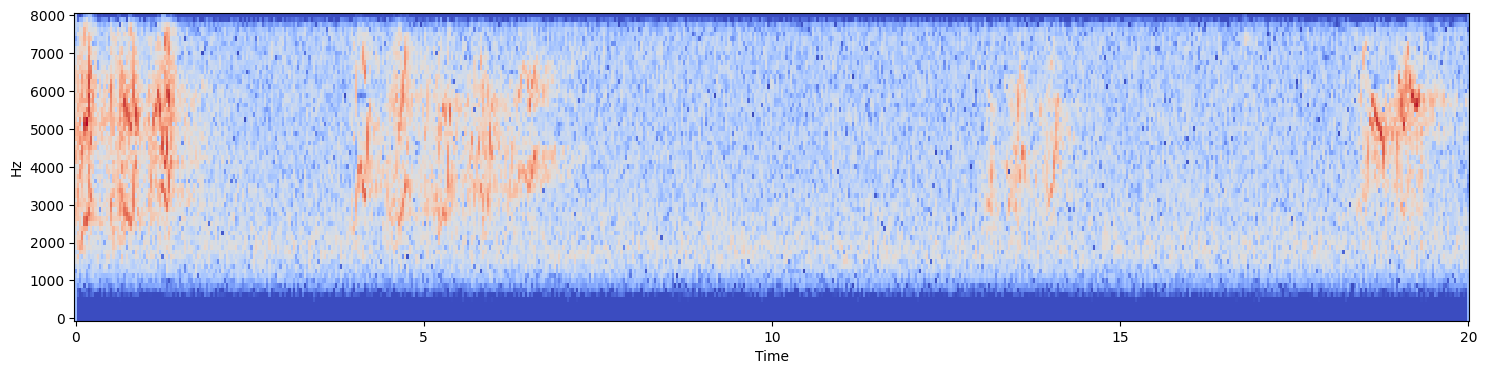

In [124]:
sample_spec = transform_frame(sample_audio, transform, transform_args)
# sample_spec = audio_to_db_stft(sample_audio, n_fft=128, hop_length=64)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=512
)

In [180]:
#sample_audio_aug = am.LowPassFilter(200, 4000, 12, 24, p=1.0)(sample_audio, 16000)
sample_audio_aug = aug(sample_audio, 16000)
Audio(sample_audio_aug, rate=16000, autoplay=True)

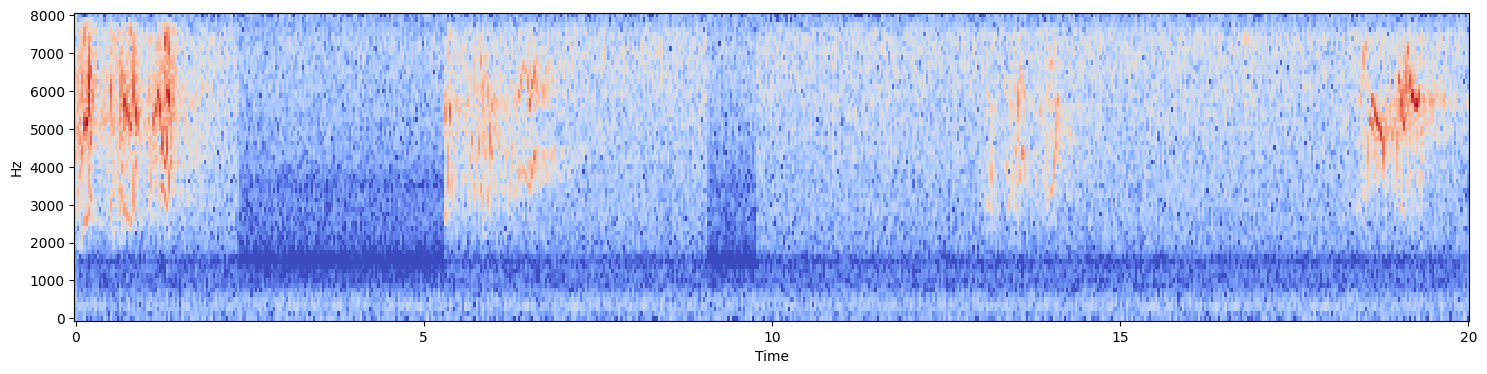

In [181]:
sample_spec_aug = transform_frame(sample_audio_aug, transform, transform_args)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec_aug
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=512
)

# Define audio sequence

In [182]:
class AudioSequence(tf.keras.utils.Sequence):
  def __init__(self
               , x
               , y
               , batch_size
               , feature_transform
               , feature_transform_args
               , durations=None
               , augmentation=None
               , shuffle=True
               , seed=42):
    self.x, self.y, self.durations = x, y, durations
    self.data_length = len(y)
    self.sample_wts = self._get_sample_weights()
    self.batch_size = batch_size

    self.augmentation = augmentation
    self.feature_transform = feature_transform
    self.feature_transform_args = feature_transform_args.copy()

    self.shuffle = shuffle
    self.indices = np.arange(self.data_length)
    self.rng = np.random.default_rng(seed=seed)
    if self.shuffle:
      self.rng.shuffle(self.indices)

  def __len__(self):
    return self.data_length // self.batch_size

  def _get_sample_weights(self):
    if self.durations is None:
      return np.ones(self.data_length)
    else:
      wts = np.array([ 1.0 - (5.0 / dur) for dur in self.durations ])
      #wts = np.array([ ((dur - 5.0) / 2.5) + 1 for dur in self.durations ])
      #wts = np.array([ (dur - 5.0) / 5.0 for dur in self.durations ])
      # wts = np.array([ dur ** 0.5 for dur in self.durations ])
      wts /= np.mean(wts)
      return wts

  def __getitem__(self, idx):
    batch_indexes = self.indices[
        idx * self.batch_size : (idx + 1) * self.batch_size
    ]
    x_batch = [self.x[i] for i in batch_indexes]
    x_batch = transform_frames(
        x_batch, get_random_clip, {'rng': self.rng}
    )
    if self.augmentation:
      x_batch = transform_frames(
          x_batch, self.augmentation, {'sample_rate': 16000}
      )
    x_fts = transform_frames(
        x_batch
        , self.feature_transform
        , self.feature_transform_args
    )
    y_labels = self.y[batch_indexes]
    wts = self.sample_wts[batch_indexes]

    return x_fts, y_labels, wts

  def on_epoch_end(self):
    if self.shuffle:
      self.rng.shuffle(self.indices)
    gc.collect()


In [183]:
BATCH_SIZE = 32

train_seq = AudioSequence(
    x=train_files
    , y=train_labels
    , batch_size=BATCH_SIZE
    , feature_transform=transform
    , feature_transform_args=transform_args
    , durations=train_durations
    , augmentation=aug
    , shuffle=True
    , seed=42
)

(array([ 6.,  0.,  4.,  2.,  2.,  0.,  0.,  3.,  4.,  3.,  1.,  2.,  2.,
         1.,  1.,  3.,  4.,  6.,  3.,  5.,  3.,  1.,  2.,  2.,  3.,  5.,
         2.,  3.,  2.,  4.,  2.,  2.,  4.,  2.,  0.,  3.,  4.,  2.,  2.,
         3.,  6.,  3.,  5.,  5.,  7.,  2.,  8.,  1.,  1.,  3.,  6.,  6.,
         5.,  7.,  3.,  5.,  2.,  6.,  6.,  5.,  3., 10.,  6.,  6.,  6.,
         5.,  9.,  6., 10., 10.,  7., 12., 10., 16.,  7., 10., 19.,  6.,
        10., 18., 12., 13., 19., 15., 13., 12., 16., 13., 16., 14., 30.,
        13., 11., 21., 14., 14., 14., 10.,  1.,  5.]),
 array([0.01173147, 0.0262726 , 0.04081374, 0.05535488, 0.06989601,
        0.08443715, 0.09897828, 0.11351942, 0.12806055, 0.14260169,
        0.15714283, 0.17168396, 0.1862251 , 0.20076623, 0.21530737,
        0.2298485 , 0.24438964, 0.25893078, 0.27347191, 0.28801305,
        0.30255418, 0.31709532, 0.33163645, 0.34617759, 0.36071873,
        0.37525986, 0.389801  , 0.40434213, 0.41888327, 0.4334244 ,
        0.44796554, 0.4625

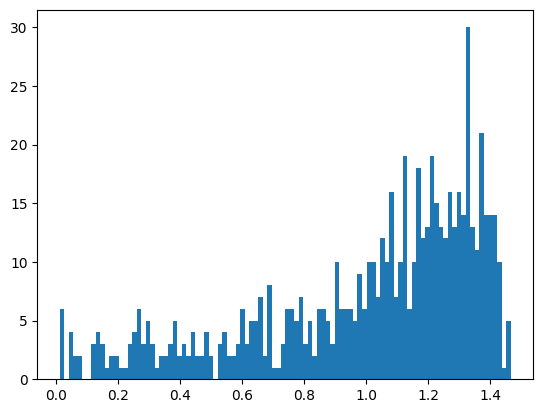

In [84]:
plt.hist(train_seq.sample_wts, bins=100)

In [134]:
train_seq_it = train_seq.__iter__()

In [135]:
next(train_seq_it)

(array([[[ 0.7143559 ,  0.76664644,  0.79144967, ...,  0.48119843,
           0.40718633,  0.29682162],
         [ 0.8015634 ,  0.85597765,  0.8760595 , ...,  0.7236997 ,
           0.64819884,  0.53963006],
         [ 0.7501107 ,  0.8176684 ,  0.84434944, ...,  0.7599978 ,
           0.688224  ,  0.6107242 ],
         ...,
         [-1.167742  , -1.1637238 , -1.1653196 , ..., -1.9641619 ,
          -2.5252016 , -3.157697  ],
         [ 1.1038339 ,  1.0608379 ,  1.2063566 , ..., -1.4248515 ,
          -1.6670883 , -1.9725553 ],
         [-2.106754  , -2.0894291 , -2.0180328 , ..., -2.5181649 ,
          -2.3084352 , -2.1635754 ]],
 
        [[ 0.20000891,  0.4189897 ,  0.58333975, ...,  1.1639986 ,
           1.0473207 ,  0.88623923],
         [ 1.1112356 ,  1.3107318 ,  1.4968326 , ...,  1.497861  ,
           1.4199166 ,  1.2934701 ],
         [ 1.592109  ,  1.6922067 ,  1.7630155 , ...,  1.0415635 ,
           0.95812553,  0.836151  ],
         ...,
         [-2.6123288 , -2.463905 

# Define Additional Layers

In [85]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        cls_randroll = np.random.randn(projection_dim) / 10
        self.cls_token = tf.Variable(
            initial_value=cls_randroll.reshape((1, 1, -1))
            , trainable=True
            , dtype=tf.float32
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        batch_len = tf.shape(patch)[0]
        cls_token_rpt = tf.repeat(self.cls_token, batch_len, axis=0)
        return tf.concat([cls_token_rpt, encoded], axis=-2)

In [86]:
class FFN(layers.Layer):
    def __init__(self, dim, middle_dim, dropout_rate):
        super().__init__()
        self.dim = dim
        self.middle_dim = middle_dim
        self.dropout_rate = dropout_rate
        self.expand = layers.Dense(middle_dim, activation=tf.nn.gelu)
        self.compress = layers.Dense(dim, activation=tf.nn.gelu)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, patch):
        x = self.expand(patch)
        x = self.dropout(x)
        x = self.compress(x)
        x = self.dropout(x)
        return x

# Define Model

In [200]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(65, 626))

add_noise = layers.GaussianDropout(rate=0.02)(inputs)

permute1 = layers.Permute((2,1))(add_noise)

add_channel = layers.Reshape(target_shape=(626, 65, 1))(permute1)

patches0 = tf.image.extract_patches(
    images=add_channel
    , sizes=[1,5,65,1]
    , strides=[1,5,65,1]
    , rates=[1,1,1,1]
    , padding='VALID'
)

patches = layers.Reshape(target_shape=(125, 325))(patches0)
pe = PatchEncoder(125, 64)
patches_enc = pe(patches)

patches_enc_ln = layers.LayerNormalization()(patches_enc)
patches_enc_mha = layers.MultiHeadAttention(
    num_heads=16
    , key_dim=4
    ,dropout=0.1
)(patches_enc_ln, patches_enc_ln)
patches_enc_skip1 = layers.Add()([patches_enc, patches_enc_mha])
patches_enc_ln2 = layers.LayerNormalization()(patches_enc_skip1)
patches_enc_ffn = FFN(64, 96, 0.35)(patches_enc_ln2)
patches_enc_skip2 = layers.Add()([patches_enc_skip1, patches_enc_ffn])

patches_enc_ln_2 = layers.LayerNormalization()(patches_enc_skip2)
patches_enc_mha_2 = layers.MultiHeadAttention(
    num_heads=16
    , key_dim=4
    ,dropout=0.1
)(patches_enc_ln_2, patches_enc_ln_2)
patches_enc_skip1_2 = layers.Add()([patches_enc_skip2, patches_enc_mha_2])
patches_enc_ln2_2 = layers.LayerNormalization()(patches_enc_skip1_2)
patches_enc_ffn_2 = FFN(64, 96, 0.35)(patches_enc_ln2_2)
patches_enc_skip2_2 = layers.Add()([patches_enc_skip1_2, patches_enc_ffn_2])

patches_enc_ln3 = layers.LayerNormalization()(patches_enc_skip2_2)
patches_enc_mha_3 = layers.MultiHeadAttention(
    num_heads=16
    , key_dim=4
    ,dropout=0.1
)(patches_enc_ln3, patches_enc_ln3)
patches_enc_skip1_3 = layers.Add()([patches_enc_skip2_2, patches_enc_mha_3])

cls_token_out = layers.Cropping1D(cropping=(0, 125))(patches_enc_skip1_3)
cls_token_out_ln = layers.LayerNormalization()(cls_token_out)
flatten = layers.Flatten()(cls_token_out_ln)
# flatten_dropout = layers.Dropout(rate=0.25)(flatten)
preds = layers.Dense(3)(flatten)


add_noise_m = tf.keras.Model(inputs, add_noise)
# patches_m = tf.keras.Model(inputs, patches)

model = tf.keras.Model(inputs, preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 626)]    0           []                               
                                                                                                  
 gaussian_dropout (GaussianDrop  (None, 65, 626)     0           ['input_1[0][0]']                
 out)                                                                                             
                                                                                                  
 permute (Permute)              (None, 626, 65)      0           ['gaussian_dropout[0][0]']       
                                                                                                  
 reshape (Reshape)              (None, 626, 65, 1)   0           ['permute[0][0]']          

In [201]:
pe.cls_token

<tf.Variable 'Variable:0' shape=(1, 1, 64) dtype=float32, numpy=
array([[[-9.8985314e-02, -9.5635936e-02,  9.7927049e-02, -5.0491177e-02,
          5.8258895e-02, -1.5640464e-01, -6.0003642e-03, -5.3282171e-02,
          1.1050914e-01,  9.9464744e-02,  7.2864883e-02,  6.4117827e-02,
         -1.4111353e-01, -6.1573166e-02, -8.0929533e-02, -5.7301510e-02,
         -1.6035965e-01,  4.6113346e-02, -7.1760647e-02, -2.8415698e-01,
         -4.2626359e-02,  1.3503159e-02, -7.1186207e-02,  1.8266972e-02,
          7.1067624e-02, -1.2571679e-01,  9.2315124e-05, -6.4531386e-02,
         -1.0294151e-01, -2.0576298e-01,  5.4222271e-02, -8.2854822e-02,
          1.4340904e-02,  3.6069900e-02, -6.4283587e-02, -1.8114405e-02,
          4.9060360e-02, -6.9651976e-02,  1.7439792e-01,  1.9792868e-01,
          4.8869234e-02,  1.0916741e-01, -5.2585583e-02, -2.9801382e-02,
          1.1447724e-02, -2.6361879e-02, -1.3168854e-01, -7.1907923e-02,
          5.4890331e-02, -1.5357140e-05,  1.1396914e-01, -3

In [202]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
    #  optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [203]:
model.fit(
    x=train_seq
    , epochs=20
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

Epoch 1/20
20/20 [==============================] - 53s 2s/step - loss: 1.3731 - acc: 0.3125 - val_loss: 1.1439 - val_acc: 0.3633
Epoch 2/20
20/20 [==============================] - 48s 2s/step - loss: 1.1793 - acc: 0.3641 - val_loss: 1.1020 - val_acc: 0.3691
Epoch 3/20
20/20 [==============================] - 64s 3s/step - loss: 1.1100 - acc: 0.3797 - val_loss: 1.0845 - val_acc: 0.4297
Epoch 4/20
20/20 [==============================] - 64s 3s/step - loss: 1.0939 - acc: 0.3688 - val_loss: 1.0827 - val_acc: 0.3909
Epoch 5/20
20/20 [==============================] - 48s 2s/step - loss: 1.1242 - acc: 0.3781 - val_loss: 1.1140 - val_acc: 0.3489
Epoch 6/20
20/20 [==============================] - 46s 2s/step - loss: 1.1001 - acc: 0.4031 - val_loss: 1.0677 - val_acc: 0.4204
Epoch 7/20
20/20 [==============================] - 49s 2s/step - loss: 1.0702 - acc: 0.4437 - val_loss: 1.0376 - val_acc: 0.4970
Epoch 8/20
20/20 [==============================] - 64s 3s/step - loss: 1.0973 - acc: 0.37

In [197]:
history1 = model.history.history.copy()

In [204]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [205]:
model.fit(
    x=train_seq
    , epochs=30
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Epoch 1/30
20/20 [==============================] - 51s 2s/step - loss: 1.0515 - acc: 0.4359 - val_loss: 0.9096 - val_acc: 0.5284
Epoch 2/30
20/20 [==============================] - 48s 2s/step - loss: 1.0300 - acc: 0.4766 - val_loss: 0.9461 - val_acc: 0.5277
Epoch 3/30
20/20 [==============================] - 48s 2s/step - loss: 1.1077 - acc: 0.4266 - val_loss: 1.1271 - val_acc: 0.3778
Epoch 4/30
20/20 [==============================] - 64s 3s/step - loss: 1.0799 - acc: 0.4062 - val_loss: 1.1716 - val_acc: 0.4092
Epoch 5/30
20/20 [==============================] - 66s 3s/step - loss: 1.0768 - acc: 0.4359 - val_loss: 1.2097 - val_acc: 0.4002
Epoch 6/30
20/20 [==============================] - 64s 3s/step - loss: 1.1048 - acc: 0.4125 - val_loss: 0.9145 - val_acc: 0.5575
Epoch 7/30
20/20 [==============================] - 65s 3s/step - loss: 1.0383 - acc: 0.4563 - val_loss: 0.9649 - val_acc: 0.5146
Epoch 8/30
20/20 [==============================] - 63s 3s/step - loss: 1.0573 - acc: 0.46

In [191]:
history2 = model.history.history.copy()

In [192]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [193]:
model.fit(
    x=train_seq
    , epochs=30
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Epoch 1/30
20/20 [==============================] - 34s 1s/step - loss: 0.4374 - acc: 0.8234 - val_loss: 0.3883 - val_acc: 0.8577
Epoch 2/30
20/20 [==============================] - 28s 1s/step - loss: 0.3951 - acc: 0.8406 - val_loss: 0.3440 - val_acc: 0.8770
Epoch 3/30
20/20 [==============================] - 39s 2s/step - loss: 0.3306 - acc: 0.8562 - val_loss: 0.3161 - val_acc: 0.8863
Epoch 4/30
20/20 [==============================] - 35s 2s/step - loss: 0.4153 - acc: 0.8484 - val_loss: 0.3146 - val_acc: 0.8888
Epoch 5/30
20/20 [==============================] - 35s 2s/step - loss: 0.4003 - acc: 0.8578 - val_loss: 0.3111 - val_acc: 0.8821
Epoch 6/30
20/20 [==============================] - 30s 1s/step - loss: 0.4076 - acc: 0.8359 - val_loss: 0.2994 - val_acc: 0.8885
Epoch 7/30
20/20 [==============================] - 34s 2s/step - loss: 0.4491 - acc: 0.8453 - val_loss: 0.3047 - val_acc: 0.8866
Epoch 8/30
20/20 [==============================] - 36s 2s/step - loss: 0.4413 - acc: 0.83

In [97]:
history3 = model.history.history.copy()

In [98]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [99]:
model.fit(
    x=train_seq
    , epochs=20
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Epoch 1/20
20/20 [==============================] - 79s 3s/step - loss: 0.2594 - acc: 0.9094 - val_loss: 0.3073 - val_acc: 0.8927
Epoch 2/20
20/20 [==============================] - 65s 3s/step - loss: 0.2828 - acc: 0.8969 - val_loss: 0.3007 - val_acc: 0.8949
Epoch 3/20
20/20 [==============================] - 75s 3s/step - loss: 0.2410 - acc: 0.9094 - val_loss: 0.2891 - val_acc: 0.8933
Epoch 4/20
20/20 [==============================] - 74s 3s/step - loss: 0.2738 - acc: 0.8906 - val_loss: 0.2841 - val_acc: 0.8949
Epoch 5/20
20/20 [==============================] - 76s 3s/step - loss: 0.2593 - acc: 0.8969 - val_loss: 0.2954 - val_acc: 0.8965
Epoch 6/20
20/20 [==============================] - 74s 3s/step - loss: 0.2802 - acc: 0.8859 - val_loss: 0.2942 - val_acc: 0.8920
Epoch 7/20
20/20 [==============================] - 73s 3s/step - loss: 0.2452 - acc: 0.9125 - val_loss: 0.2922 - val_acc: 0.8917
Epoch 8/20
20/20 [==============================] - 69s 3s/step - loss: 0.2355 - acc: 0.90

In [100]:
history4 = model.history.history.copy()

In [103]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [104]:
model.fit(
    x=train_seq
    , epochs=30
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Epoch 1/30
20/20 [==============================] - 101s 5s/step - loss: 0.2296 - acc: 0.9266 - val_loss: 0.2842 - val_acc: 0.8994
Epoch 2/30
20/20 [==============================] - 66s 3s/step - loss: 0.2279 - acc: 0.9078 - val_loss: 0.2810 - val_acc: 0.9004
Epoch 3/30
20/20 [==============================] - 66s 3s/step - loss: 0.2400 - acc: 0.9141 - val_loss: 0.2865 - val_acc: 0.9007
Epoch 4/30
20/20 [==============================] - 66s 3s/step - loss: 0.2389 - acc: 0.9219 - val_loss: 0.2729 - val_acc: 0.9036
Epoch 5/30
20/20 [==============================] - 93s 4s/step - loss: 0.2175 - acc: 0.9203 - val_loss: 0.2778 - val_acc: 0.9029
Epoch 6/30
20/20 [==============================] - 67s 3s/step - loss: 0.1929 - acc: 0.9344 - val_loss: 0.2767 - val_acc: 0.9026
Epoch 7/30
20/20 [==============================] - 73s 3s/step - loss: 0.2369 - acc: 0.9078 - val_loss: 0.2867 - val_acc: 0.9010
Epoch 8/30
20/20 [==============================] - 75s 3s/step - loss: 0.2232 - acc: 0.9

Process Keras_worker_ForkPoolWorker-693:
Process Keras_worker_ForkPoolWorker-696:
Process Keras_worker_ForkPoolWorker-695:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-694:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/data_utils.py", line 647, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/lib/python3.10/multiproc

KeyboardInterrupt: ignored

In [105]:
history5 = model.history.history.copy()

In [ ]:
model.save(gdi.join_to_shared('notebooks/AL/models/ViT_mfcc.keras'))

In [ ]:
model2 = tf.keras.models.load_model(gdi.join_to_shared('notebooks/AL/models/ViT_1.keras')
  , custom_objects={"PatchEncoder": PatchEncoder, "FFN": FFN}
)

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1251)]   0           []                               
                                                                                                  
 gaussian_dropout (GaussianDrop  (None, 33, 1251)    0           ['input_1[0][0]']                
 out)                                                                                             
                                                                                                  
 permute (Permute)              (None, 1251, 33)     0           ['gaussian_dropout[0][0]']       
                                                                                                  
 reshape (Reshape)              (None, 1251, 33, 1)  0           ['permute[0][0]']          

In [ ]:
patch_enc_m2 = tf.keras.Model(
    inputs=model2.input
    , outputs=model2.get_layer('layer_normalization_4').output
)

In [ ]:
model2.get_layer('patch_encoder_1').get_weights()[3]

array([[ 0.04808214, -0.02497224,  0.02779267, ..., -0.08437417,
         0.0118306 , -0.02504291],
       [-0.01145187, -0.02962087,  0.04457357, ...,  0.07873098,
         0.11699288,  0.01071569],
       [-0.00724811,  0.01515337,  0.01124441, ..., -0.01321097,
         0.00043546,  0.06517572],
       ...,
       [ 0.08712531,  0.02741945, -0.02845596, ...,  0.03064393,
         0.09317464, -0.00104974],
       [-0.00391965,  0.0706066 , -0.03613025, ...,  0.00423967,
         0.01406963, -0.04596414],
       [-0.04259229,  0.01450546,  0.00913536, ..., -0.08333138,
         0.11010785,  0.08607494]], dtype=float32)

# Plot History

In [106]:
history = {}

for key in history1.keys():
  history[key] = history1[key] + history2[key] + history3[key] + history4[key]

history

{'loss': [1.3252993822097778,
  1.1184828281402588,
  0.9640318751335144,
  0.8293711543083191,
  0.7372038960456848,
  0.6675179600715637,
  0.638359785079956,
  0.6475247144699097,
  0.6405137181282043,
  0.5158256888389587,
  0.6870719790458679,
  0.6432034373283386,
  0.5195876359939575,
  0.5549576282501221,
  0.5742915272712708,
  0.5054647326469421,
  0.45134347677230835,
  0.421919047832489,
  0.4758170247077942,
  0.47502022981643677,
  0.362106055021286,
  0.4114503860473633,
  0.33064156770706177,
  0.31090572476387024,
  0.359662264585495,
  0.3987371325492859,
  0.313774049282074,
  0.3433239459991455,
  0.28190165758132935,
  0.3622954785823822,
  0.3248274028301239,
  0.3084695637226105,
  0.33806225657463074,
  0.28472742438316345,
  0.3003564178943634,
  0.2947002053260803,
  0.33664414286613464,
  0.28269681334495544,
  0.2834305167198181,
  0.2829309403896332,
  0.25940415263175964,
  0.2828141748905182,
  0.24101963639259338,
  0.2738068997859955,
  0.25932726263999

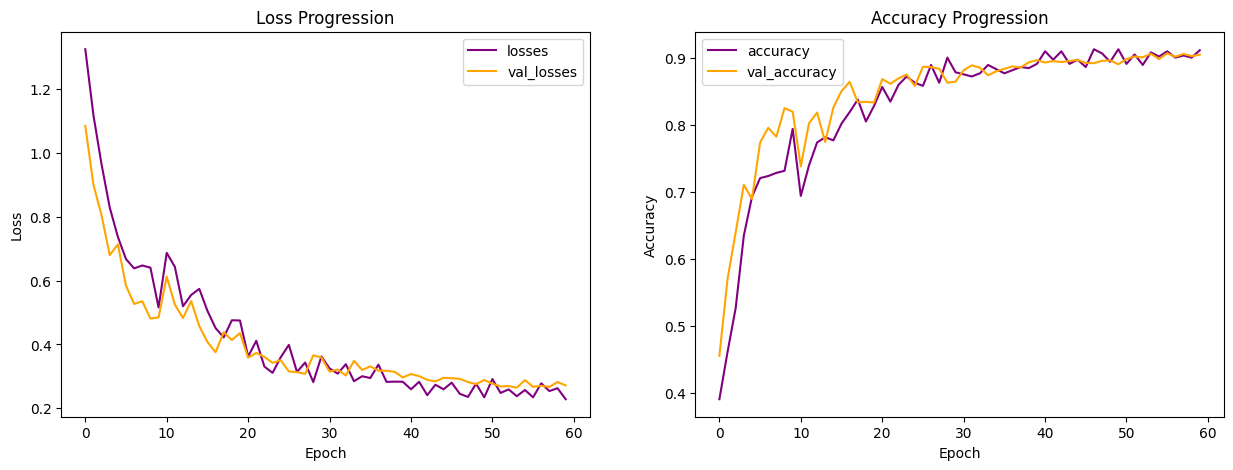

In [107]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

axes[0].plot(history['loss'], color='purple', label='losses')
axes[0].plot(history['val_loss'], color='orange', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(history['acc'], color='purple', label='accuracy')
axes[1].plot(history['val_acc'], color='orange', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()
plt.show()

In [ ]:
history_filepath = gdi.join_to_shared('notebooks/AL/models/ViT_mfcc.pkl')
with open(history_filepath, 'wb') as file:
  pkl.dump(history, file)

# See results

In [ ]:
sample_audio_num = 1095
sample_audio = val_frames[sample_audio_num]
sample_audio_aug = aug(sample_audio, 16000)
sample_spec = transform_frame(sample_audio, transform, transform_args)
sample_spec_aug = transform_frame(sample_audio_aug, transform, transform_args)

sample_audio_info = val_frame_df.iloc[sample_audio_num]
sample_audio_info

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


data                                      val
primary_label                         eaywag1
primary_label_enc                           2
filename                 eaywag1/XC654684.ogg
filename_npy             eaywag1/XC654684.npy
rating                                   poor
type                                     call
type_enc                                    2
country                                    UZ
country_enc                                57
continent                                ASIA
continent_enc                               2
file_duration_s                        18.886
file_duration_samples                  302176
frame_length_s                            5.0
hop_length_s                              2.5
total_frames                                6
frame_id                                    4
Name: 1095, dtype: object

In [ ]:
Audio(sample_audio, rate=16000, autoplay=True)

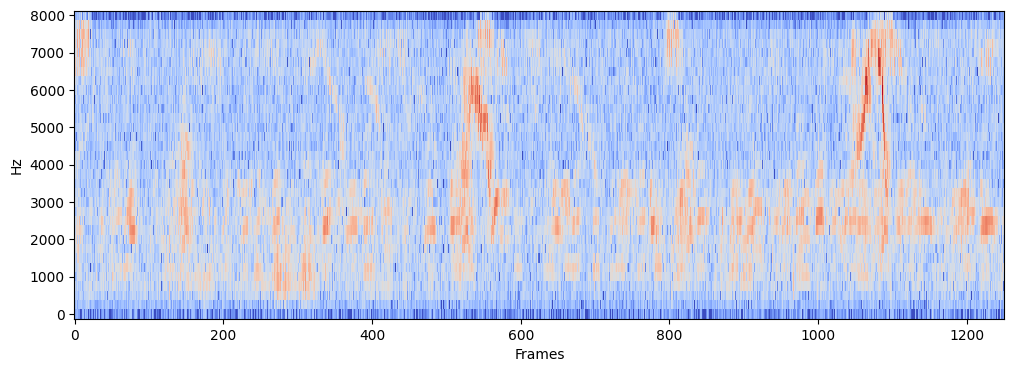

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.specshow(
    sample_spec
    , x_axis='frames'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

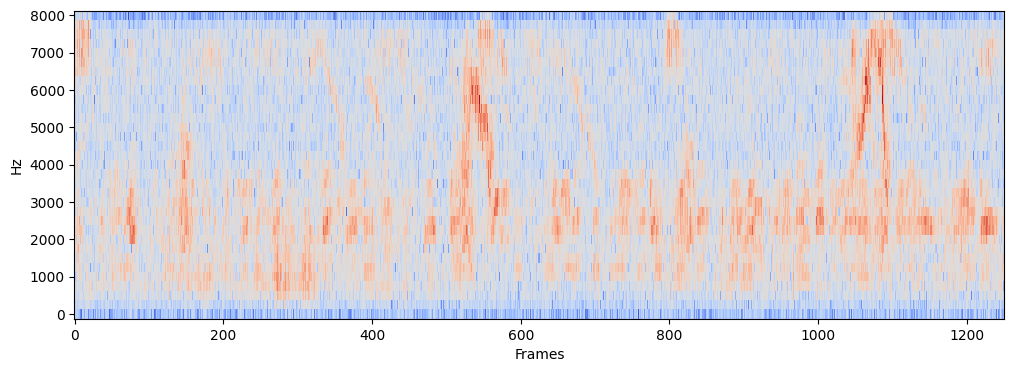

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.specshow(
    np.array(tf.squeeze(add_noise_m((np.array([sample_spec])), training=True)))
    , x_axis='frames'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

In [ ]:
sample_audio_info['primary_label_enc']

2

In [ ]:
layers.Softmax()(model2(np.array([sample_spec])))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5.1008686e-03, 7.0565799e-04, 9.9419349e-01]], dtype=float32)>

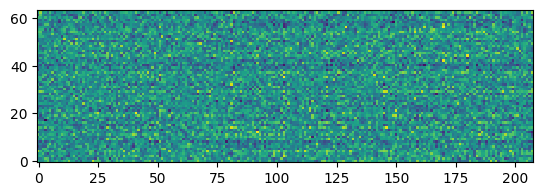

In [ ]:
plt.imshow(model2.get_layer('patch_encoder_1').get_weights()[3].T, aspect='equal', origin='lower', interpolation='none')

In [ ]:
# lstm_out = tf.squeeze(patch_enc_m2((np.array([sample_spec]))))
lstm_out = patch_enc_m2((np.array([sample_spec])))

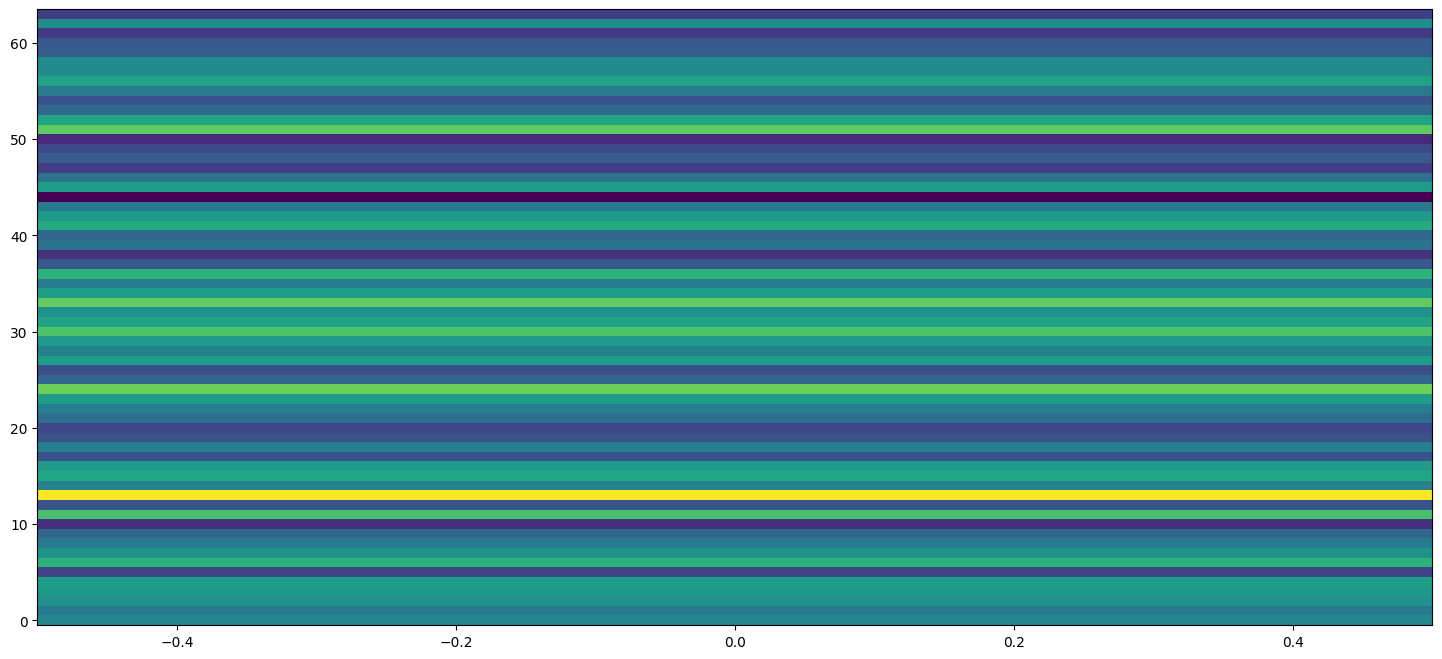

In [ ]:
plt.figure(figsize=(18,8))
plt.imshow(np.array(lstm_out).T, aspect='auto', origin='lower', interpolation='none')

In [ ]:
dense_out = tf.squeeze(dense_m((np.array([sample_spec_aug]))))

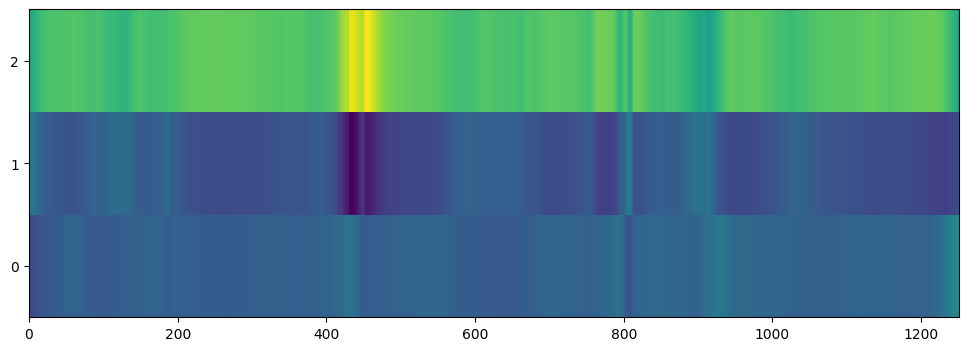

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(np.array(dense_out).T, aspect='auto', origin='lower', interpolation='none')
plt.yticks([0, 1, 2])
plt.show()

In [ ]:
mask_out = tf.squeeze(mask_dense_sm_m((np.array([sample_spec_aug]))))

<ipython-input-198-719fd9d2ee77>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.1e}'.format(y) for y in plt.gca().get_yticks()])


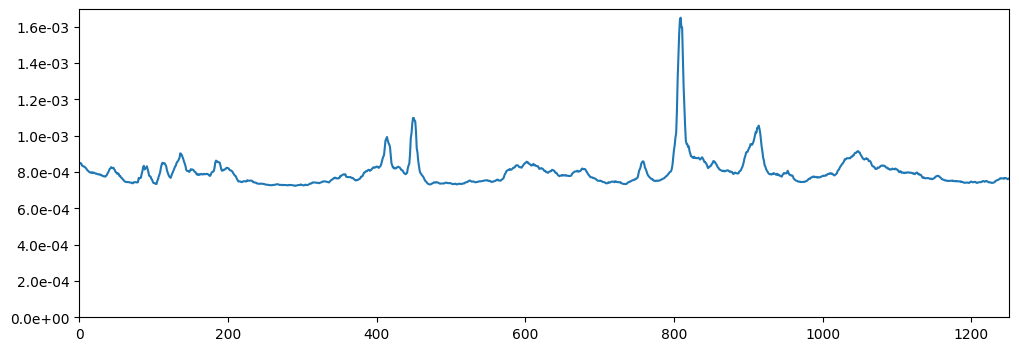

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(mask_out)
plt.xlim((0, 1251))
plt.ylim(bottom=0.)
plt.gca().set_yticklabels(['{:.1e}'.format(y) for y in plt.gca().get_yticks()])
plt.show()